# Utilities

In [4]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS functions

In [1]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [6]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
#     popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
#     trend = funcfit3(timess, *popt)
    trend = gaussian_filter1d(data, 10)

    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# Get Data

In [7]:
ds = xr.open_dataset('CMIP6_amoc.nc')

In [8]:
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

In [11]:
strn26.load()
strn35.load()
index.load()

<xarray.DataArray 'index' (models: 34, ensemble_members: 10, year: 165)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -9.83567818,  -9.96747804,  -9.87559962, ...,  -9.8192265 ,
          -9.53018165,  -9.60423207],
        [ -9.26724124,  -9.20765185,  -9.62124856, ..., -10.28693318,
         -10.51233848, -10.22079849],
        [ -9.45160929,  -9.45961754,  -9.54747669, ..., -10.22823318,
         -10.1423463 ,  -9.9231437 ],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -8.9466881 ,  -9.2422324 ,  -9.27880526, ...,  -9.5742743 ,
          -9.38110113,  -9.47151629],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * models            (models) object 'AWI-CM-1-1-MR' ... 'SAM0-UNICON'
  * year              (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * ensemble_members  (ensemble_members) object 'r1i1p1f1' ... 'r10i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 18219 characters

In [12]:
yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

# Make EWS files

## lambda

In [58]:
def runlam(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)
    xs[: w//2] = np.nan
    xs[n-w//2:] = np.nan

    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()
        lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
        p0 = lg[0]
        p1 = lg[1]
        xw = xw - p0 * np.arange(xw.shape[0]) - p1

        dxw = xw[1:] - xw[:-1]
         # a, b = np.polyfit(xw[:-1], dxw, 1)
        lg = st.linregress(xw[:-1], dxw)[:]
        a = lg[0]
        b = lg[1]

        xs[i] = np.log(a + 1)
    return xs

In [153]:
def runlam2(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)
    xs[: w//2] = np.nan
    xs[n-w//2:] = np.nan

    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()
        lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
        p0 = lg[0]
        p1 = lg[1]
        xw = xw - p0 * np.arange(xw.shape[0]) - p1

        dxw = xw[1:] - xw[:-1]
         # a, b = np.polyfit(xw[:-1], dxw, 1)
        lg = st.linregress(xw[:-1], dxw)[:]
        a = lg[0]
        b = lg[1]

        xs[i] = a
    return xs

# ws 70

In [160]:
def make_lambda_array(data,ws=70,gedge=5):
    lambdas = np.full((data.shape[0],data.shape[1],data.shape[2]-2*gedge),np.nan)
    for i in np.arange(0,data.shape[0]):
        for j in np.arange(0,data.shape[1]):
            amoc = np.nan_to_num(data[i,j].values)
            amoc_low = gaussian_filter1d(amoc, 10)
            if amoc.sum() != 0:
                lamb = runlam((amoc-amoc_low)[gedge:-gedge],ws)
                lambdas[i,j,:]=lamb
    return lambdas

In [180]:
strn26_lambda = make_lambda_array(strn26, ws=70)
strn35_lambda = make_lambda_array(strn35, ws=70)
index_lambda = make_lambda_array(index, ws=70)
lambdas = xr.Dataset(
    data_vars = dict(index_lambda=(['models','ensemble_members','time'],index_lambda),
                     strn35_lambda=(['models','ensemble_members','time'],strn35_lambda),
                     strn26_lambda=(['models','ensemble_members','time'],strn26_lambda)),
    coords = dict(
            time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Lambda for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 70 yrs')
)
# lambdas.to_netcdf('EWS_files/CMIP6_lambdas_new_w70.nc')

/tmp/ipykernel_13335/3977239817.py:21: RuntimeWarning: invalid value encountered in log
  xs[i] = np.log(a + 1)


## trends and pvs of linear trend

In [173]:
import scipy.stats as st
def make_kendall_array(lambdas,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    lambda_taus = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    lambda_pvs = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    for i in np.arange(0,lambdas.shape[0]):
        for j in np.arange(0,lambdas.shape[1]):
            lam = np.nan_to_num(lambdas[i,j,:][bound : -bound])
            if lam.sum() != 0:
                tau = st.kendalltau(tt,lam)
                lambda_pvs[i,j]=tau[1]
                lambda_taus[i,j]=tau[0]
    return lambda_pvs, lambda_taus

In [183]:
# lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas_new_w70.nc')
strn26_pvs, strn26_taus = make_kendall_array(lambdas.strn26_lambda.values,lambdas.time.values)
strn35_pvs, strn35_taus = make_kendall_array(lambdas.strn35_lambda.values,lambdas.time.values)
index_pvs, index_taus = make_kendall_array(lambdas.index_lambda.values,lambdas.time.values)
lambda_pvs = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
                     strn35_pvs=(['models','ensemble_members'],strn35_pvs),
                     strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
# lambda_pvs.to_netcdf('EWS_files/CMIP6_lambda_kendall_pvs_new.nc')
lambda_taus = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_taus),
                     strn35_pvs=(['models','ensemble_members'],strn35_taus),
                     strn26_pvs=(['models','ensemble_members'],strn26_taus)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
# lambda_taus.to_netcdf('EWS_files/CMIP6_lambda_kendall_taus_new.nc')

In [170]:
lambda_taus = xr.open_dataset('EWS_files/CMIP6_lambda_kendall_taus_new.nc')

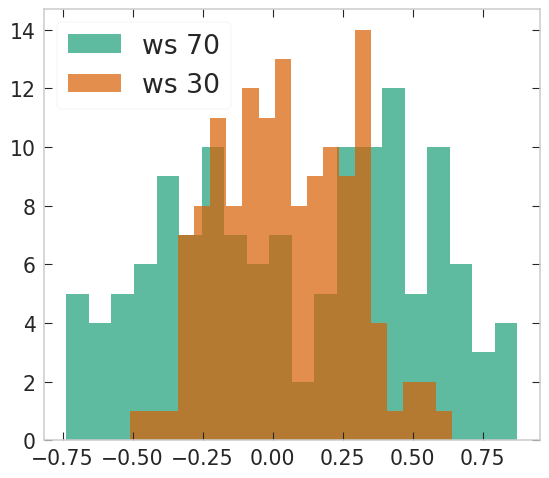

In [184]:
# lambda_taus = xr.open_dataset('EWS_files/CMIP6_lambda_kendall_taus_new.nc')
data = lambda_taus.strn35_pvs
plt.hist(data.values.ravel(),bins=20,alpha=0.7,label='ws 70')
lambda_taus = xr.open_dataset('EWS_files/CMIP6_lambda_kendall_taus_new_w30.nc')
data = lambda_taus.strn35_pvs
plt.hist(data.values.ravel(),bins=20,alpha=0.7,label='ws 30')
plt.legend()
plt.show()

In [185]:
def make_pvs_array(lambdas,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    lambda_pvs = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    for i in np.arange(0,lambdas.shape[0]):
        for j in np.arange(0,lambdas.shape[1]):
            lam = np.nan_to_num(lambdas[i,j,:][bound : -bound].values)
            if lam.sum() != 0:
                p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
                pv = kendall_tau_test(lam[:-2], 10000, p0)
                lambda_pvs[i,j]=pv
    return lambda_pvs

In [186]:
strn26_pvs = make_pvs_array(lambdas.strn26_lambda,lambdas.time,ws=70)
strn35_pvs = make_pvs_array(lambdas.strn35_lambda,lambdas.time,ws=70)
index_pvs = make_pvs_array(lambdas.index_lambda,lambdas.time,ws=70)
lambda_pvs = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
                     strn35_pvs=(['models','ensemble_members'],strn35_pvs),
                     strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.\n Using 10000 fourier surrogates')
)
lambda_pvs.to_netcdf('EWS_files/CMIP6_lambda_pvs_new.nc')

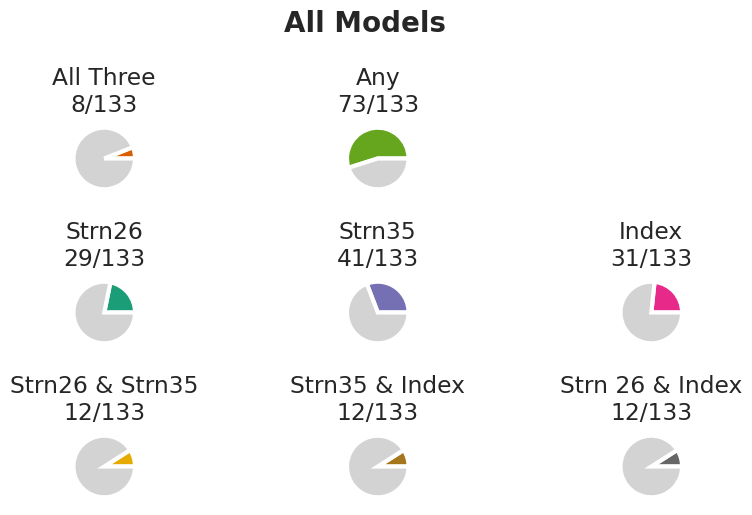

In [187]:
min_pv = 0.05

EWS_all = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strn26 = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv))
EWS_strn35 = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv))
EWS_index = lambda_pvs.where(
           (lambda_pvs.index_pvs<=min_pv))

EWS_any = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv) |
            (lambda_pvs.strn35_pvs<=min_pv) |
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strns = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv))
EWS_strn35indx = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))
EWS_strn26indx = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))

N_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(EWS_strn26indx.strn26_pvs.values))

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0,0])
data = [N_all,N_tot-N_all]
patches, texts= ax.pie(
data,
    colors = ['C1','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('All Three\n{}/{}'.format(N_all,N_tot))

ax = fig.add_subplot(gs[0,1])
data = [N_any,N_tot-N_any]
patches, texts= ax.pie(
data,
    colors = ['C4','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Any\n{}/{}'.format(N_any,N_tot))

ax = fig.add_subplot(gs[1,0])
data = [N_s26,N_tot-N_s26]
patches, texts= ax.pie(
data,
colors = ['C0','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26\n{}/{}'.format(N_s26,N_tot))

ax = fig.add_subplot(gs[1,1])
data = [N_s35,N_tot-N_s35]
patches, texts= ax.pie(
data,
    colors = ['C2','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35\n{}/{}'.format(N_s35,N_tot))

ax = fig.add_subplot(gs[1,2])
data = [N_indx,N_tot-N_indx]
patches, texts= ax.pie(
data,
    colors = ['C3','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Index\n{}/{}'.format(N_indx,N_tot))



ax = fig.add_subplot(gs[2,0])
data = [N_strns,N_tot-N_strns]
patches, texts= ax.pie(
data,
colors = ['C5','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26 & Strn35\n{}/{}'.format(N_strns,N_tot))

ax = fig.add_subplot(gs[2,1])
data = [N_strn35indx,N_tot-N_strn35indx]
patches, texts= ax.pie(
data,
    colors = ['C6','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35 & Index\n{}/{}'.format(N_strn35indx,N_tot))

ax = fig.add_subplot(gs[2,2])
data = [N_strn26indx,N_tot-N_strn26indx]
patches, texts= ax.pie(
data,
    colors = ['C7','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn 26 & Index\n{}/{}'.format(N_strn26indx,N_tot))


fig.subplots_adjust(hspace=1)
fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
plt.show()

In [122]:
min_pv = 0.5

EWS_all = lambda_taus.where(
           ((lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.strn35_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv)))
EWS_strn26 = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv))
EWS_strn35 = lambda_taus.where(
           (lambda_taus.strn35_pvs>=min_pv))
EWS_index = lambda_taus.where(
           (lambda_taus.index_pvs>=min_pv))

EWS_any = lambda_taus.where(
           ((lambda_taus.strn26_pvs>=min_pv) |
            (lambda_taus.strn35_pvs>=min_pv) |
            (lambda_taus.index_pvs>=min_pv)))
EWS_strns = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.strn35_pvs>=min_pv))
EWS_strn35indx = lambda_taus.where(
           (lambda_taus.strn35_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv))
EWS_strn26indx = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


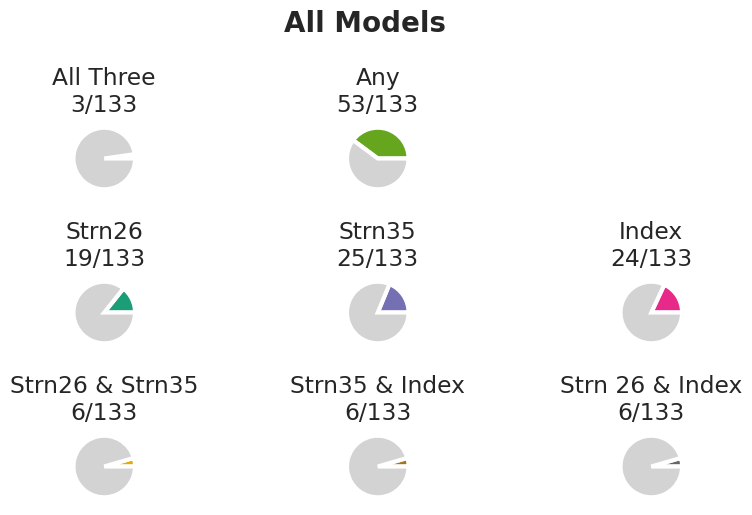

In [123]:
N_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(EWS_strn26indx.strn26_pvs.values))

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0,0])
data = [N_all,N_tot-N_all]
patches, texts= ax.pie(
data,
    colors = ['C1','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('All Three\n{}/{}'.format(N_all,N_tot))

ax = fig.add_subplot(gs[0,1])
data = [N_any,N_tot-N_any]
patches, texts= ax.pie(
data,
    colors = ['C4','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Any\n{}/{}'.format(N_any,N_tot))

ax = fig.add_subplot(gs[1,0])
data = [N_s26,N_tot-N_s26]
patches, texts= ax.pie(
data,
colors = ['C0','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26\n{}/{}'.format(N_s26,N_tot))

ax = fig.add_subplot(gs[1,1])
data = [N_s35,N_tot-N_s35]
patches, texts= ax.pie(
data,
    colors = ['C2','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35\n{}/{}'.format(N_s35,N_tot))

ax = fig.add_subplot(gs[1,2])
data = [N_indx,N_tot-N_indx]
patches, texts= ax.pie(
data,
    colors = ['C3','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Index\n{}/{}'.format(N_indx,N_tot))



ax = fig.add_subplot(gs[2,0])
data = [N_strns,N_tot-N_strns]
patches, texts= ax.pie(
data,
colors = ['C5','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26 & Strn35\n{}/{}'.format(N_strns,N_tot))

ax = fig.add_subplot(gs[2,1])
data = [N_strn35indx,N_tot-N_strn35indx]
patches, texts= ax.pie(
data,
    colors = ['C6','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35 & Index\n{}/{}'.format(N_strn35indx,N_tot))

ax = fig.add_subplot(gs[2,2])
data = [N_strn26indx,N_tot-N_strn26indx]
patches, texts= ax.pie(
data,
    colors = ['C7','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn 26 & Index\n{}/{}'.format(N_strn26indx,N_tot))


fig.subplots_adjust(hspace=1)
fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
plt.show()

# ws 30

In [124]:
strn26_lambda = make_lambda_array(strn26, ws=30)
strn35_lambda = make_lambda_array(strn35, ws=30)
index_lambda = make_lambda_array(index, ws=30)
lambdas = xr.Dataset(
    data_vars = dict(index_lambda=(['models','ensemble_members','time'],index_lambda),
                     strn35_lambda=(['models','ensemble_members','time'],strn35_lambda),
                     strn26_lambda=(['models','ensemble_members','time'],strn26_lambda)),
    coords = dict(
            time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Lambda for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 70 yrs')
)
lambdas.to_netcdf('EWS_files/CMIP6_lambdas_new_w30.nc')

/tmp/ipykernel_13335/3977239817.py:21: RuntimeWarning: invalid value encountered in log
  xs[i] = np.log(a + 1)


In [126]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas_new_w30.nc')
strn26_pvs, strn26_taus = make_kendall_array(lambdas.strn26_lambda.values,lambdas.time.values,ws=30)
strn35_pvs, strn35_taus = make_kendall_array(lambdas.strn35_lambda.values,lambdas.time.values,ws=30)
index_pvs, index_taus = make_kendall_array(lambdas.index_lambda.values,lambdas.time.values,ws=30)
lambda_pvs = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
                     strn35_pvs=(['models','ensemble_members'],strn35_pvs),
                     strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
lambda_pvs.to_netcdf('EWS_files/CMIP6_lambda_kendall_pvs_new_w30.nc')
lambda_taus = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_taus),
                     strn35_pvs=(['models','ensemble_members'],strn35_taus),
                     strn26_pvs=(['models','ensemble_members'],strn26_taus)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
lambda_taus.to_netcdf('EWS_files/CMIP6_lambda_kendall_taus_new_w30.nc')

In [149]:
min_pv = 0.5

EWS_all = lambda_taus.where(
           ((lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.strn35_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv)))
EWS_strn26 = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv))
EWS_strn35 = lambda_taus.where(
           (lambda_taus.strn35_pvs>=min_pv))
EWS_index = lambda_taus.where(
           (lambda_taus.index_pvs>=min_pv))

EWS_any = lambda_taus.where(
           ((lambda_taus.strn26_pvs>=min_pv) |
            (lambda_taus.strn35_pvs>=min_pv) |
            (lambda_taus.index_pvs>=min_pv)))
EWS_strns = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.strn35_pvs>=min_pv))
EWS_strn35indx = lambda_taus.where(
           (lambda_taus.strn35_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv))
EWS_strn26indx = lambda_taus.where(
           (lambda_taus.strn26_pvs>=min_pv)&
            (lambda_taus.index_pvs>=min_pv))

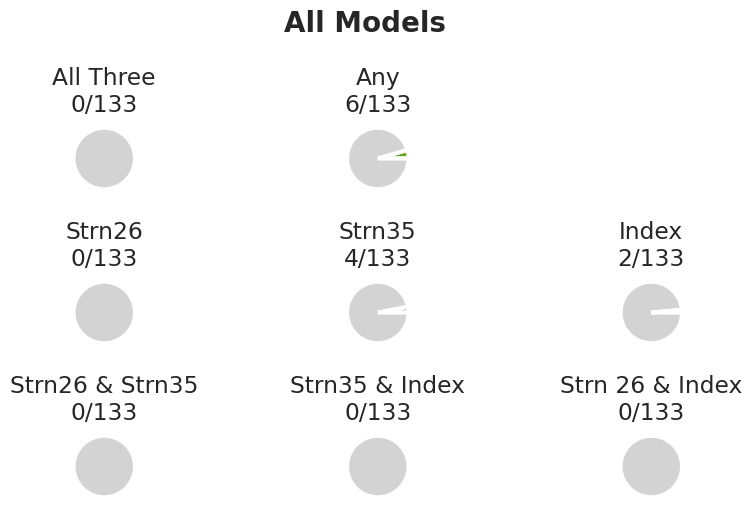

In [150]:
N_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(EWS_strn26indx.strn26_pvs.values))

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0,0])
data = [N_all,N_tot-N_all]
patches, texts= ax.pie(
data,
    colors = ['C1','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('All Three\n{}/{}'.format(N_all,N_tot))

ax = fig.add_subplot(gs[0,1])
data = [N_any,N_tot-N_any]
patches, texts= ax.pie(
data,
    colors = ['C4','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Any\n{}/{}'.format(N_any,N_tot))

ax = fig.add_subplot(gs[1,0])
data = [N_s26,N_tot-N_s26]
patches, texts= ax.pie(
data,
colors = ['C0','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26\n{}/{}'.format(N_s26,N_tot))

ax = fig.add_subplot(gs[1,1])
data = [N_s35,N_tot-N_s35]
patches, texts= ax.pie(
data,
    colors = ['C2','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35\n{}/{}'.format(N_s35,N_tot))

ax = fig.add_subplot(gs[1,2])
data = [N_indx,N_tot-N_indx]
patches, texts= ax.pie(
data,
    colors = ['C3','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Index\n{}/{}'.format(N_indx,N_tot))



ax = fig.add_subplot(gs[2,0])
data = [N_strns,N_tot-N_strns]
patches, texts= ax.pie(
data,
colors = ['C5','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26 & Strn35\n{}/{}'.format(N_strns,N_tot))

ax = fig.add_subplot(gs[2,1])
data = [N_strn35indx,N_tot-N_strn35indx]
patches, texts= ax.pie(
data,
    colors = ['C6','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35 & Index\n{}/{}'.format(N_strn35indx,N_tot))

ax = fig.add_subplot(gs[2,2])
data = [N_strn26indx,N_tot-N_strn26indx]
patches, texts= ax.pie(
data,
    colors = ['C7','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn 26 & Index\n{}/{}'.format(N_strn26indx,N_tot))


fig.subplots_adjust(hspace=1)
fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
plt.show()

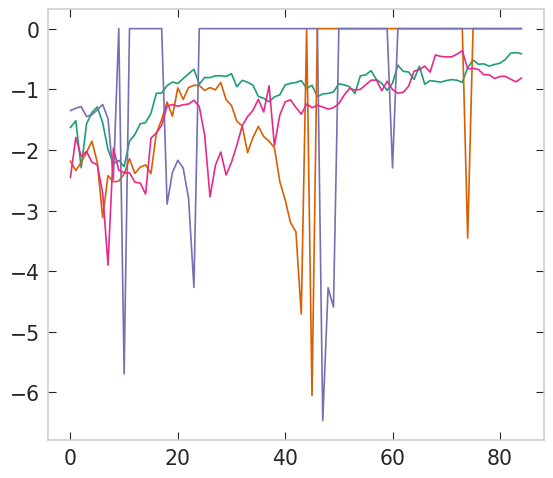

In [152]:
bound = 35
data = lambdas.where((lambda_taus.strn35_pvs>=0.5)).strn35_lambda
for i in np.arange(0,34):
    for j in np.arange(0,10):
        lam = np.nan_to_num(data[i,j,:][bound : -bound])
        if lam.sum() != 0:
            plt.plot(lam)

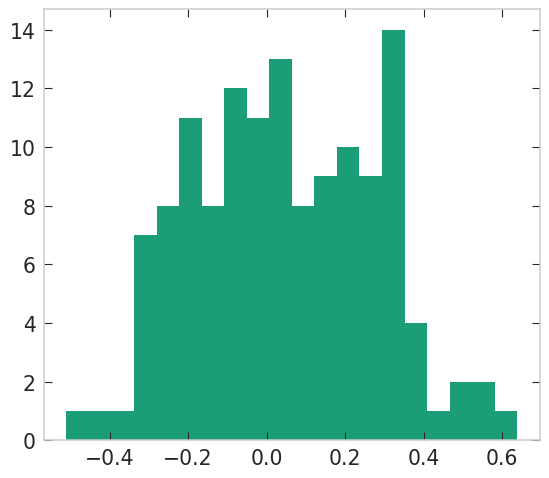

In [159]:
bound = 35
data = lambda_taus.strn35_pvs
plt.hist(data.values.ravel(),bins=20)
plt.show()